# Assignment 10: Collider with RF cavity -- Solution

<html>
<div class="alert alert-info" role="alert" style="margin-top: 10px">
    <ul>
        <li>Parse MADX file of a collider</li>
        <li>Implement thin RF cavity trasfer matrix and insert into collider</li>
        <li>Track Twiss and dispersion</li>
    </ul>
</div>
</html>

## Load MADX file
A PSI colleague prepared a fantasy collider example in MAD-X. In the first cell we parse this file using our ```MADXParser``` class. This class provides some useful functions and attributes for you:
```Python
madx = MADXParser()
    
# fn is the MAD-X file to parse
madx.parse(fn)
    
# returns all elements in ascending order in a list.
madx.getBeamline()

# returns an instance of the particle, e.g. proton, electron, etc.
madx.getParticle()

# returns the total energy [GeV]
madx.getEtot()
```

<html>
    <div class="alert alert-info" style="background-color:rgba(255, 0, 0, 0.6);
                                         margin-top:10px;
                                         color:white;
                                         border-color:rgba(255, 0, 0, 0.3)">
        <strong>If you use google colab, run this cell:</strong>
    </div>
</html>

<html>
    <div class="alert alert-info" style="background-color:rgba(255, 0, 0, 0.6);
                                         margin-top:10px;
                                         color:white;
                                         border-color:rgba(255, 0, 0, 0.3)">
<strong>If you run it locally, run</strong>
               </div>
</html>

```bash
$ cd .../pam1-hs2021
...pam1-hs2021$ git pull
```
<html>
    <div class="alert alert-info" style="background-color:rgba(255, 0, 0, 0.6);
                                         margin-top:10px;
                                         color:white;
                                         border-color:rgba(255, 0, 0, 0.3)">
to get the updated repository.</div></html>

In [1]:
from AcceLEGOrator.MADXParser import *

try:
    madx = MADXParser()
    
    madx.parse('madx/collider_madx.mad')
    
    print(madx)
    
    beamline = madx.getBeamline()
    
except Exception as e:
    print(e)

**********************************************************************
MADX-Parser information:
         length:	203.6000039999999 [m]
      #elements:	450
            *       #drift:	244
            *      #dipole:	72
            *  #quadrupole:	114
           beam:	
            *     particle:	electron
            * total energy:	1.0 [GeV]
**********************************************************************


## Thin RF-Cavity
From the Eq. (36) of `pam-s9` we know
$$
R =
\begin{pmatrix}
1 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & -\frac{1}{f_{||}} & 1 \\
\end{pmatrix},
$$
where
$$
\frac{1}{f_{||}} = \frac{q\hat{V}}{P_0c}k\cos\phi_0,
$$
with voltage $\hat{V}$, $k=2\pi f_{RF}/c$ where $f_{RF}$ is the RF frequency, and $\phi_0$ is the RF phase.

Note that we need to calculate the energy gain through the cavity, and change the gamma factor accordingly. The energy gain due to the RF-Cavity is given by
$$
\Delta W = |q|\hat{V}T\cos(\phi_0),
$$
with voltage $\hat{V}$, charge $q$, RF phase $\phi_0$ and transit time factor
$$
T = \frac{2\beta_0}{\pi}\sin\left(\frac{\pi}{2\beta_0}\right).
$$

<html>
    <div class="alert alert-info" style="background-color:rgba(255, 0, 0, 0.6);
                                         margin-top:10px;
                                         color:white;
                                         border-color:rgba(255, 0, 0, 0.3)">
<strong>TODO</strong>
        <ol>
            <li>Implement the Thin RF-Cavity map.</li>
        </ol>
               </div>
</html>

In [2]:
from AcceLEGOrator import Map, Physics, Constants
from AcceLEGOrator import Parameter as param
import numpy as np

class ThinRfCavity(Map):
    
    # param voltage [V]
    # param freq RF frequency [MHz]
    # param phase [rad]
    def __init__(self, V, freq, phase):
        
        self.V = V
        self.freq = freq
        self.phase = phase
        
        beta_0  = Physics.getBeta(param.gamma_0)
        
        c = Constants.clight
        
        #  [k] = 1 / m
        k = 2.0 * np.pi * freq * 1e6 / c
        
        # [P0] = eV / c
        P0 = param.mass * 1e6 * param.gamma_0 * beta_0
        
        # [f] = m
        f = param.charge * V / P0 * k * np.cos(phase)
        
        R = np.matrix([[1, 0, 0, 0, 0, 0],
                       [0, 1, 0, 0, 0, 0],
                       [0, 0, 1, 0, 0, 0],
                       [0, 0, 0, 1, 0, 0],
                       [0, 0, 0, 0, 1, 0],
                       [0, 0, 0, 0, -f, 1]])
        
        # transit time factor
        fac = 2.0 * beta_0 / np.pi
        T = fac * np.sin(1.0 / fac)
        
        # energy gain [MeV]
        W = abs(param.charge) * V * T * np.cos(phase)
        
        # new relativistic factor and logging
        self.gamma_before = param.gamma_0
        param.gamma_0 += W / param.mass
        self.gamma_after = param.gamma_0
        
        super(ThinRfCavity, self).__init__(R, 0)
    
    
    def __str__(self):
        return 'ThinRfCavity(V = ' + str(self.V) + ' [V], '\
               + 'rf freq = ' + str(self.freq) + ' [MHz], '\
               + 'rf phase = ' + str(self.phase) + ' [rad])\n'
    
    def get(self, length):
        return ThinRfCavity(self.V, self.freq, self.phase)

<html>
    <div class="alert alert-info" role="alert" style="margin-top: 10px">
        Our collider will have two RF-Cavities with $\hat{V} = 0.001$ MV, $\phi = 0$ and
        $f_{rf} = 10^{-4}$ MHz.
    </div>
</html>

In [3]:
RF_1 = ThinRfCavity(V=1000, freq=1e-4, phase=0)
RF_2 = ThinRfCavity(V=1000, freq=1e-4, phase=0)

## Find where to insert the cavities by tracking the dispersion

<html>
    <div class="alert alert-info" style="background-color:rgba(255, 0, 0, 0.6);
                                         margin-top:10px;
                                         color:white;
                                         border-color:rgba(255, 0, 0, 0.3)">
        <strong>TODO:</strong>
        <ol>
            <li>Use the function `trackDispersion` in `Tracking.py` to track the dispersion with the following initial values. Since we alreadyd have the entire beamline, we should set cell=beamline and n_cells=1.</li>
            $$\begin{pmatrix}D_x \\ D_{p_x} \\ 1 \end{pmatrix}
            =\begin{pmatrix} 0.5069938765 \\ −0.1681363086 \\ 1\end{pmatrix}$$
            <li>plot the result</li>
        </ol>
    </div>
</html>

You can find more details about dispersion in
[this link](https://indico.cern.ch/event/471931/contributions/1149878/attachments/1214721/1794333/Lectures.pdf)

(For a FODO cell, the calculation of initial dispersion is given in Slide 119)

In [4]:
from AcceLEGOrator import Tracking
initial_dispersion = [0.5069938765, -0.1681363086, 1]
all_dispersions, lengths = Tracking.trackDispersion(initial_dispersion, cell=beamline, n_cells=1, n_slice=1)

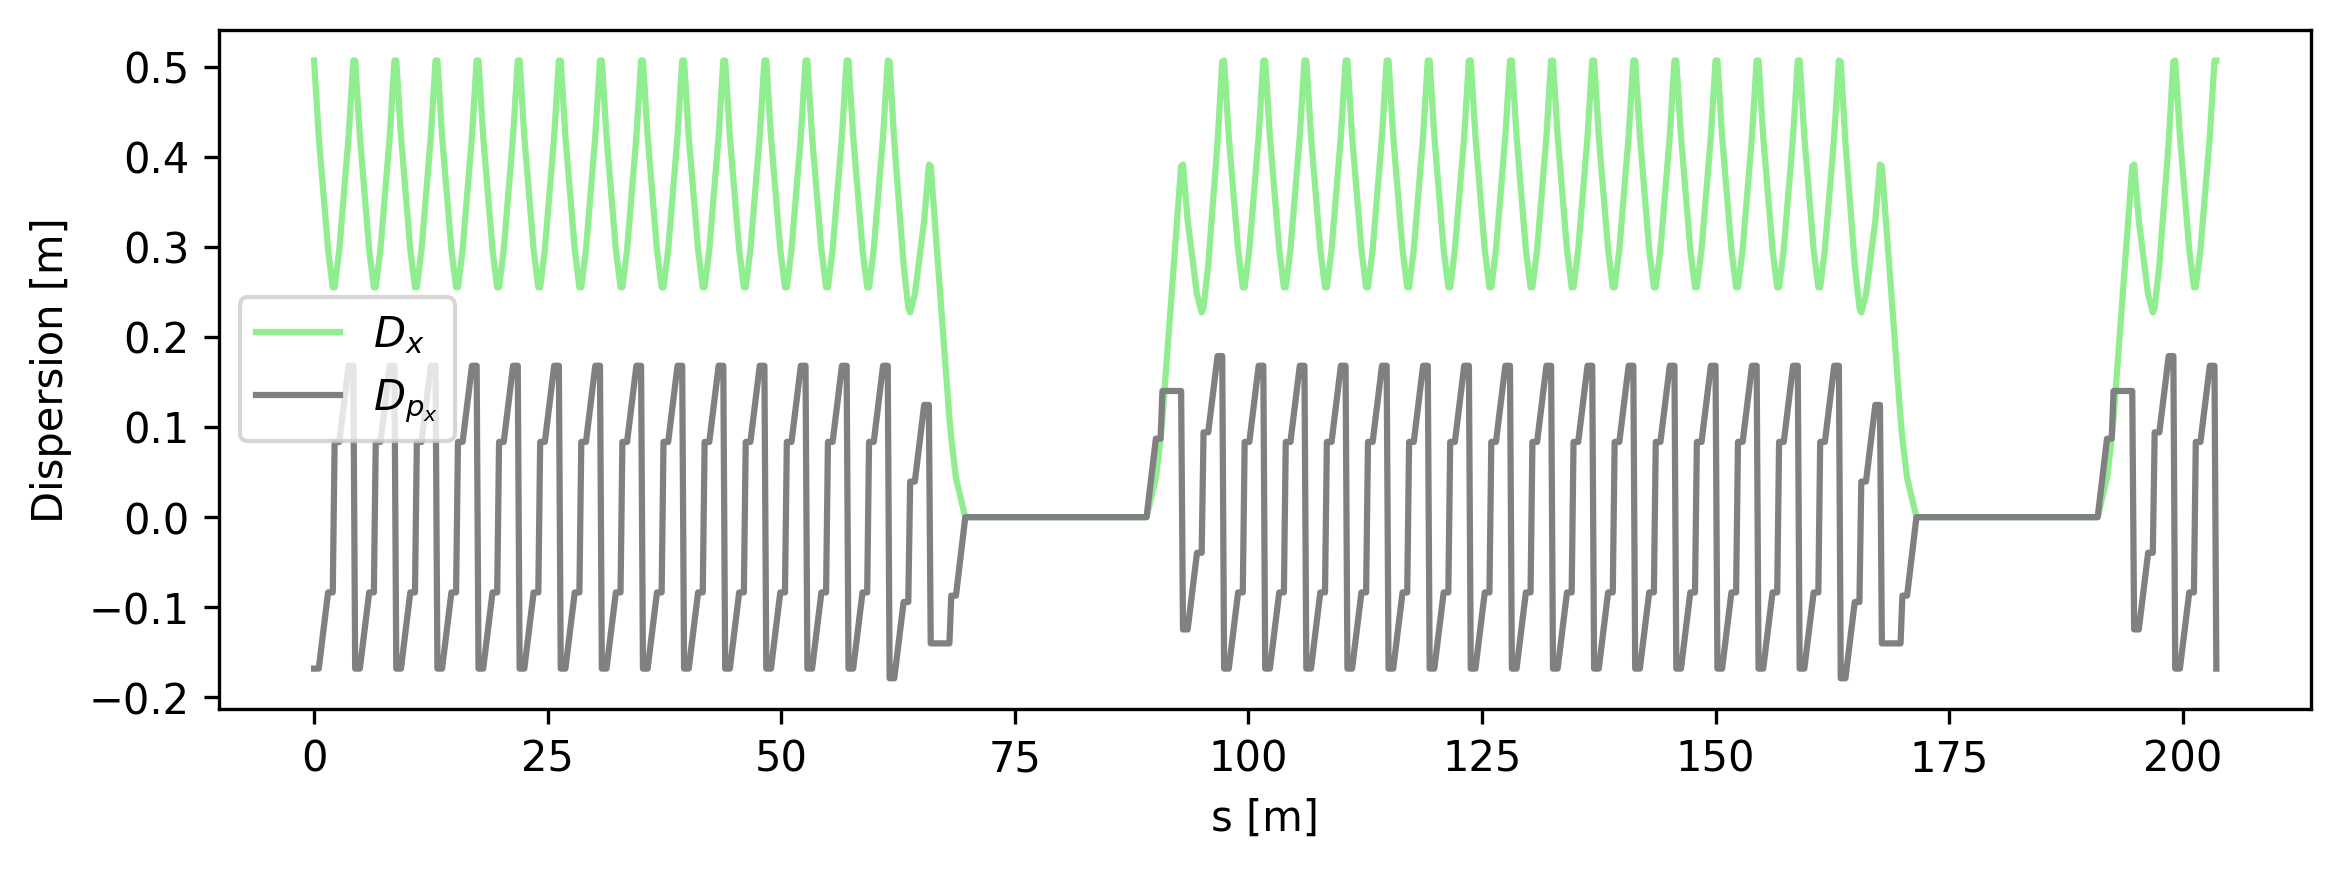

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure(dpi=300)
fig.set_size_inches(9,3)
axis = fig.add_subplot(111)
axis.set_xlabel('s [m]')
axis.set_ylabel('Dispersion [m]')

axis.plot(lengths, all_dispersions[:, 0], label=r'$D_x$', color='lightgreen')
axis.plot(lengths, all_dispersions[:, 1], label=r'$D_{p_x}$', color='gray')
axis.legend()

plt.show()

<html>
    <div class="alert alert-info" style="background-color:rgba(255, 0, 0, 0.6);
                                         margin-top:10px;
                                         color:white;
                                         border-color:rgba(255, 0, 0, 0.3)">
        <strong>TODO:</strong>
        <ol>
            <li>Locate the middle index of the two regions in the beamline where dispersion is zero</li>
            <li>Insert the above defined Thin RF-Cavity to the two locations.</li>
        </ol>
    </div>
</html>

In [6]:
np.where(all_dispersions[:, 0] < 1e-3)[0] # indices where Dx<0.001

array([126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
       191, 192, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351,
       352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364,
       365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377,
       378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390,
       391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403,
       404, 405, 406, 407])

There are two regions: from 126 to 192, and from 341 to 407

In [7]:
index1 = int((126+192)/2)
index2 = int((341+407)/2)
beamline.insert(index1, RF_1)
beamline.insert(index2, RF_2)

<html>
    <div class="alert alert-info" style="background-color:rgba(255, 0, 0, 0.6);
                                         margin-top:10px;
                                         color:white;
                                         border-color:rgba(255, 0, 0, 0.3)">
        <strong>TODO:</strong>
        <ol>
            <li>Locate the middle index of the two regions in the beamline where dispersion is zero</li>
            <li>Insert the above defined Thin RF-Cavity to the two locations.</li>
        </ol>
    </div>
</html>

## Tracking of $\beta$

We will repreduce this plot:
![twiss_dispersion_rf](img/twiss_dispersion_rf.png)

To track the Twiss parameters, the initial Twiss need to match the FODO part of the beam. By looking into the MAD-X file, we find the following lines:
```
rfbdb : line=(d, b, d, qd0, d, b, d, qf0);
arc   : line=(6*rfbdb, d, b, d, qd0, d, b, d, 6*fbdb);
half  : line=(arc, iacr);
ring  : line=(half, half);
```
This means that our `ring` consists of 2 `half`s, which starts with `arc`, which then contains 6 identical FODO cells with dipole inserted in between, i.e. `rfbdb` where d means Drift, b beams bending magnet (Dipole) and qd* means Quadrupole. Therefore we need to use the first 48 elements in our beamline to calculate the initial Twiss.
<html>
    <div class="alert alert-info" style="background-color:rgba(255, 0, 0, 0.6);
                                         margin-top:10px;
                                         color:white;
                                         border-color:rgba(255, 0, 0, 0.3)">
        <strong>TODO:</strong>
        <ul>
            <li>Get the initial Twiss parameter from the FODO part of the beamline, using the `getTwissInitial` function in `Tracking.py`.</li>
            <li>Use `trackTwiss` and `trackDispersion` in `Tracking.py` to reproduce the above plot. Now our beamline has been changed, so we need to redo the tracking.</li>
        </ul>
    </div>
</html>

In [8]:
# for x plane
ax0, bx0 = Tracking.getTwissInitial(beamline[:48], axis='x')
gx0 = (1 + ax0**2) / bx0

# for y plane
ay0, by0 = Tracking.getTwissInitial(beamline[:48], axis='y')
gy0 = (1 + ay0**2) / by0

# initial container of the twiss parameters
twiss_init = [ax0, bx0, gx0, ay0, by0, gy0]
twiss_init

[-2.344980128034432,
 7.112474625785789,
 0.9137370806659821,
 0.5166323413669266,
 1.3592142987535671,
 0.932089205733091]

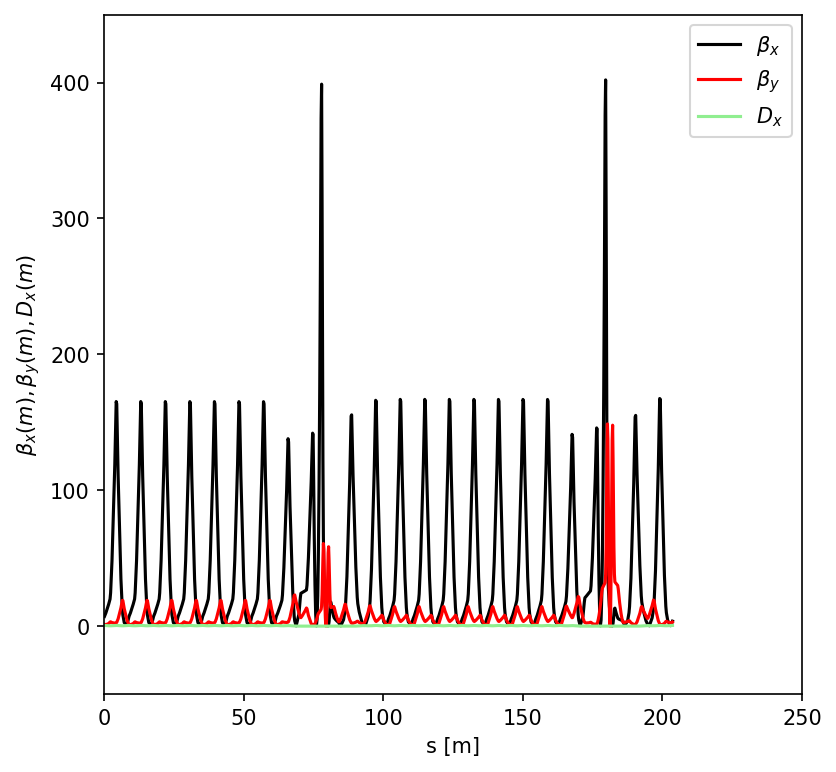

In [9]:
# track Twiss
all_twiss, lengths = Tracking.trackTwiss(cell=beamline, n_cells=1, n_slice=1, twiss_init=twiss_init)
# track Dispersion
all_dispersions, _ = Tracking.trackDispersion(initial_dispersion, cell=beamline, n_cells=1, n_slice=1)

fig = plt.figure(dpi=150)
fig.set_size_inches(6,6)
axis = fig.add_subplot(111)
axis.set_xlabel('s [m]')
axis.set_ylabel(r'$\beta_x(m), \beta_y(m), D_x(m)$')

axis.plot(lengths, all_twiss[:, 1], label=r'$\beta_x$', color='black')
axis.plot(lengths, all_twiss[:, 4], label=r'$\beta_y$', color='red')
axis.plot(lengths, all_dispersions[:, 0], label=r'$D_x$', color='lightgreen')
axis.set_xlim([0, 250])
axis.set_ylim([-50, 450])
axis.legend()

plt.show()

## Energy change

Note that we have define `gamma_before` and `gamma_after` for the RF cavity. This is to log the energy change due to the cavity.
<html>
    <div class="alert alert-info" style="background-color:rgba(255, 0, 0, 0.6);
                                         margin-top:10px;
                                         color:white;
                                         border-color:rgba(255, 0, 0, 0.3)">
        <strong>TODO:</strong>
        <ul>
            <li>For the two cativies in our beamline, print the gamma factors before and after them to see the energy change.</li>
            <li>*Bonus: Plot the energy against lengths s. You should get a 2-step ladder shape.</li>
        </ul>
    </div>
</html>

In [10]:
RF_1 = beamline[index1]
RF_2 = beamline[index2]
print(RF_1.gamma_before, RF_1.gamma_after)
print(RF_2.gamma_before, RF_2.gamma_after)

1956.9511835591836 3202.7848379150455
3202.7848379150455 4448.618594200969
